In [ ]:
!pip install keras-facenet
!pip install mtcnn
!pip install opencv-python
!pip install numpy
!pip install scipy
!pip install zip_files

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.7 MB/s eta 0:00:0000:01
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10369 sha256=154a3a11f9f306c4b6c6129052f90538daa61c9964ce9081e1ae5454e8fd203a
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [14]:
def enhance_face(face_image):
    enhanced_face = gaussian_filter(face_image, sigma=1.0)
    return enhanced_face

In [15]:
from mtcnn import MTCNN
import cv2
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import zipfile
import io
from keras_facenet import FaceNet

In [ ]:


# # Example usage
# classroom_image_paths = ['/kaggle/input/class-images/IMG-20241111-WA0012.jpg', '/kaggle/input/class-images/IMG-20241111-WA0013.jpg', '/kaggle/input/class-images/IMG-20241111-WA0014.jpg','/kaggle/input/class-images/IMG-20241111-WA0015.jpg','/kaggle/input/class-images/IMG-20241111-WA0016.jpg','/kaggle/input/class-images/IMG-20241111-WA0017.jpg']
# output_folder = 'new_extracted_faces'
# zip_filename = 'new_extracted_faces.zip'
# detect_and_extract_faces(classroom_image_paths, output_folder, zip_filename)
# print(f"Faces extracted, enhanced, and saved to '{zip_filename}' in '{output_folder}' folder.")

In [16]:
def detect_and_extract_faces(classroom_image_paths, output_folder, zip_filename):
  
    detector = MTCNN()
    
    os.makedirs(output_folder, exist_ok=True)
    
    zip_path = os.path.join(output_folder, zip_filename)
    with zipfile.ZipFile(zip_path, 'w') as zip_file:
        for image_idx, classroom_image_path in enumerate(classroom_image_paths):
            classroom_image = cv2.imread(classroom_image_path)
            
            detected_faces = detector.detect_faces(classroom_image)
            
            for face_idx, face in enumerate(detected_faces):
                x, y, width, height = [int(v) for v in face['box']]
                face_image = classroom_image[y:y+height, x:x+width]
                enhanced_face = enhance_face(face_image)
                
                _, buffer = cv2.imencode('.jpg', enhanced_face)
                zip_file.writestr(f"classroom_{image_idx+1}_face_{face_idx+1}.jpg", buffer.tobytes())

In [18]:
def preprocess_image(image, target_size=(160, 160)):
    """
    Preprocess image to standard size while maintaining aspect ratio with padding
    """
    if image is None:
        return None
        
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    height, width = image.shape[:2]
    
    scale = min(target_size[0]/width, target_size[1]/height)
    new_width = int(width * scale)
    new_height = int(height * scale)
    
    resized = cv2.resize(image, (new_width, new_height))
    
    new_image = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    
    x_offset = (target_size[1] - new_width) // 2
    y_offset = (target_size[0] - new_height) // 2
    
    new_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized
    
    return new_image

def generate_embeddings(dataset_path):
    """
    Generate embeddings for all faces in the dataset using keras-facenet
    """
    print("Initializing FaceNet model...")
    embedder = FaceNet()
    print("Model initialized successfully!")
    
    embeddings = []
    labels = []
    processed_images = []
    
    print("Processing images...")
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        
        if os.path.isdir(folder_path):
            label = folder_name
            image_path = os.path.join(folder_path, f"{folder_name}.jpg")
            
            if os.path.exists(image_path):
                try:
                    # Read the image
                    face_img = cv2.imread(image_path)
                    if face_img is not None:
                        # Preprocess the image
                        processed_face = preprocess_image(face_img)
                        
                        if processed_face is not None:
                            processed_images.append(processed_face)
                            labels.append(label)
                            print(f"Processed image for label: {label}")
                        else:
                            print(f"Failed to process image: {image_path}")
                    else:
                        print(f"Failed to read image: {image_path}")
                except Exception as e:
                    print(f"Error processing {image_path}: {str(e)}")
    
    if processed_images:
        try:
            # Convert processed images list to numpy array
            images_array = np.array(processed_images)
            print(f"Images array shape: {images_array.shape}")
            
            # Generate embeddings for all images at once
            print("Generating embeddings...")
            embeddings = embedder.embeddings(images_array)
            print(f"Successfully generated embeddings for {len(embeddings)} images")
            
        except Exception as e:
            print(f"Error generating embeddings: {str(e)}")
            return np.array([]), np.array([])
    
    return np.array(embeddings), np.array(labels)

In [19]:

from mtcnn import MTCNN
import cv2
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import zipfile
import io
from keras_facenet import FaceNet

def main():
    try:
        dataset_path = "/kaggle/input/d/jetaniharshil/cvdldata/proper"
        
        embeddings, labels = generate_embeddings(dataset_path)
        
        if len(embeddings) > 0:
            # Save embeddings and labels
            np.save('face_embeddings.npy', embeddings)
            np.save('face_labels.npy', labels)
            
            print(f"Generated embeddings shape: {embeddings.shape}")
            print(f"Number of labeled faces processed: {len(labels)}")
        else:
            print("No embeddings were generated. Please check the error messages above.")
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

Initializing FaceNet model...
Model initialized successfully!
Processing images...
Processed image for label: 23BCE535
Processed image for label: 22BCE335
Processed image for label: 22BCE182
Processed image for label: 22BCE062
Processed image for label: 22BCE002
Processed image for label: 22BCE004
Processed image for label: 22BCE231
Processed image for label: 22BCE275
Processed image for label: 22BCE046
Processed image for label: 22BCE355
Processed image for label: 22BCE187
Processed image for label: 22BCE056
Processed image for label: 22BCE148
Processed image for label: 22BCE015
Processed image for label: 23BCE517
Processed image for label: 22BCE284
Processed image for label: 22BCE199
Processed image for label: 22BCE327
Processed image for label: 22BCE323
Processed image for label: 22BCE185
Processed image for label: 23BCE531
Processed image for label: 22BCE389
Processed image for label: 22BCE328
Images array shape: (23, 160, 160, 3)
Generating embeddings...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4

In [30]:
# import cv2
# import numpy as np
# from mtcnn import MTCNN
# from keras_facenet import FaceNet
# from scipy.spatial.distance import cosine
# import os

# def recognize_faces_in_class(class_image_path, stored_embeddings_path, stored_labels_path, output_path, threshold=0.7):
#     """
#     Recognize faces in a class image using stored embeddings and generate annotated output
    
#     Args:
#         class_image_path: Path to the class image
#         stored_embeddings_path: Path to stored embeddings .npy file
#         stored_labels_path: Path to stored labels .npy file
#         output_path: Path to save the annotated image
#         threshold: Similarity threshold for face matching (default: 0.7)
#     """
#     # Load the stored embeddings and labels
#     stored_embeddings = np.load(stored_embeddings_path)
#     stored_labels = np.load(stored_labels_path)
    
#     # Initialize MTCNN and FaceNet
#     detector = MTCNN()
#     embedder = FaceNet()
    
#     # Read the class image
#     class_image = cv2.imread(class_image_path)
#     if class_image is None:
#         raise ValueError("Could not read the class image")
    
#     # Convert BGR to RGB for MTCNN
#     rgb_image = cv2.cvtColor(class_image, cv2.COLOR_BGR2RGB)
    
#     # Detect faces
#     detected_faces = detector.detect_faces(rgb_image)
    
#     # Create a copy for drawing
#     annotated_image = class_image.copy()
    
#     # Process each detected face
#     for face_info in detected_faces:
#         # Extract face box coordinates
#         x, y, width, height = [int(v) for v in face_info['box']]
        
#         # Add margin to the face box (10% of width/height)
#         margin_x = int(width * 0.1)
#         margin_y = int(height * 0.1)
        
#         # Calculate coordinates with margin, ensuring they stay within image bounds
#         x1 = max(0, x - margin_x)
#         y1 = max(0, y - margin_y)
#         x2 = min(class_image.shape[1], x + width + margin_x)
#         y2 = min(class_image.shape[0], y + height + margin_y)
        
#         # Extract and preprocess face
#         face_img = class_image[y1:y2, x1:x2]
#         processed_face = preprocess_image(face_img)
        
#         if processed_face is not None:
#             # Generate embedding for the detected face
#             face_embedding = embedder.embeddings(np.array([processed_face]))[0]
            
#             # Find the best match
#             min_distance = float('inf')
#             best_match_label = "Unknown"
            
#             for stored_embedding, stored_label in zip(stored_embeddings, stored_labels):
#                 distance = cosine(face_embedding, stored_embedding)
#                 if distance < min_distance:
#                     min_distance = distance
#                     if distance < threshold:
#                         best_match_label = stored_label
            
#             # Draw bounding box and label
#             color = (0, 255, 0) if best_match_label != "Unknown" else (0, 0, 255)
#             cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
            
#             # Add label with background
#             label = f"{best_match_label} ({min_distance:.2f})"
#             label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
#             cv2.rectangle(annotated_image, (x1, y1 - label_size[1] - 10), 
#                          (x1 + label_size[0], y1), color, cv2.FILLED)
#             cv2.putText(annotated_image, label, (x1, y1 - 5),
#                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
#     # Save the annotated image
#     cv2.imwrite(output_path, annotated_image)
#     return annotated_image

# # Example usage
# def main():
#     # Paths
#     class_image_path = "/kaggle/input/enhance/enhance image.jpg"
#     stored_embeddings_path = "/kaggle/working/face_embeddings_with_aug.npy"
#     stored_labels_path = "/kaggle/working/face_labels_with_aug.npy"
#     output_path = "/kaggle/working/annotated_class_image.jpg"
    
#     try:
#         # Process the class image and generate annotated output
#         annotated_image = recognize_faces_in_class(
#             class_image_path,
#             stored_embeddings_path,
#             stored_labels_path,
#             output_path,
#             threshold=0.3  # Adjust this threshold based on your needs
#         )
#         print(f"Annotated image saved to: {output_path}")
        
#     except Exception as e:
#         print(f"Error processing class image: {str(e)}")

# if __name__ == "__main__":
#     main()
import cv2
import numpy as np
from mtcnn import MTCNN
from keras_facenet import FaceNet
from scipy.spatial.distance import cosine
import os
import pandas as pd

def recognize_faces_in_class(class_image_path, stored_embeddings_path, stored_labels_path, output_path, excel_output_path, threshold=0.7):
    """
    Recognize faces in a class image using stored embeddings and generate annotated output
    
    Args:
        class_image_path: Path to the class image
        stored_embeddings_path: Path to stored embeddings .npy file
        stored_labels_path: Path to stored labels .npy file
        output_path: Path to save the annotated image
        excel_output_path: Path to save the Excel file with filename and labels
        threshold: Similarity threshold for face matching (default: 0.7)
    """
    # Load the stored embeddings and labels
    stored_embeddings = np.load(stored_embeddings_path)
    stored_labels = np.load(stored_labels_path)
    
    # Initialize MTCNN and FaceNet
    detector = MTCNN()
    embedder = FaceNet()
    
    # Read the class image
    class_image = cv2.imread(class_image_path)
    if class_image is None:
        raise ValueError("Could not read the class image")
    
    # Convert BGR to RGB for MTCNN
    rgb_image = cv2.cvtColor(class_image, cv2.COLOR_BGR2RGB)
    
    # Detect faces
    detected_faces = detector.detect_faces(rgb_image)
    
    # Create a copy for drawing
    annotated_image = class_image.copy()
    
    # Store filename and detected labels for the Excel file
    excel_data = []
    unique_filenames = set()  # Track unique filenames

    # Process each detected face
    for face_info in detected_faces:
        # Extract face box coordinates
        x, y, width, height = [int(v) for v in face_info['box']]
        
        # Add margin to the face box (10% of width/height)
        margin_x = int(width * 0.1)
        margin_y = int(height * 0.1)
        
        # Calculate coordinates with margin, ensuring they stay within image bounds
        x1 = max(0, x - margin_x)
        y1 = max(0, y - margin_y)
        x2 = min(class_image.shape[1], x + width + margin_x)
        y2 = min(class_image.shape[0], y + height + margin_y)
        
        # Extract and preprocess face
        face_img = class_image[y1:y2, x1:x2]
        processed_face = preprocess_image(face_img)
        
        if processed_face is not None:
            # Generate embedding for the detected face
            face_embedding = embedder.embeddings(np.array([processed_face]))[0]
            
            # Find the best match
            min_distance = float('inf')
            best_match_label = "Unknown"
            
            for stored_embedding, stored_label in zip(stored_embeddings, stored_labels):
                distance = cosine(face_embedding, stored_embedding)
                if distance < min_distance:
                    min_distance = distance
                    if distance < threshold:
                        best_match_label = stored_label
                        if(best_match_label!="Unknown"):
                               unique_filenames.add(best_match_label)

                            
            
            # Draw bounding box and label
            color = (0, 255, 0) if best_match_label != "Unknown" else (0, 0, 255)
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
            
            # Add label with background
            label = f"{best_match_label} ({min_distance:.2f})"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
            cv2.rectangle(annotated_image, (x1, y1 - label_size[1] - 10), 
                         (x1 + label_size[0], y1), color, cv2.FILLED)
            cv2.putText(annotated_image, label, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            # Append to Excel data
            # excel_data.append({"Filename":best_match_label, "Label": P })
    
    # Save the annotated image
    cv2.imwrite(output_path, annotated_image)


    for a in unique_filenames:
        excel_data.append({"Filename":a, "Label": "P" })

    # Save results to Excel
    excel_df = pd.DataFrame(excel_data)
    excel_df.to_excel(excel_output_path, index=False)
    
    print(f"Annotated image saved to: {output_path}")
    print(f"Excel file saved to: {excel_output_path}")
    return annotated_image

# Example usage
def main():
    # Paths
    class_image_path = "/kaggle/input/enhance/enhance image.jpg"
    stored_embeddings_path = "/kaggle/working/face_embeddings_with_aug.npy"
    stored_labels_path = "/kaggle/working/face_labels_with_aug.npy"
    output_path = "/kaggle/working/annotated_class_image.jpg"
    excel_output_path = "/kaggle/working/class_image_results.xlsx"
    
    try:
        # Process the class image and generate annotated output
        annotated_image = recognize_faces_in_class(
            class_image_path,
            stored_embeddings_path,
            stored_labels_path,
            output_path,
            excel_output_path,
            threshold=0.3  # Adjust this threshold based on your needs
        )
        
    except Exception as e:
        print(f"Error processing class image: {str(e)}")

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━

# Augmentation

In [1]:
!pip install imgaug


In [2]:
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt

def augment_image(image):
    """
    Apply a series of augmentations to the input image.
    Returns a list of augmented images.
    """
    augmenters = iaa.Sequential([
        iaa.Fliplr(0.5),  # Horizontal flip with 50% probability
        iaa.Rotate((-15, 15)),  # Rotate by -15 to 15 degrees
        iaa.Multiply((0.8, 1.2)),  # Adjust brightness
        iaa.Affine(scale=(0.9, 1.1))  # Scale images
    ])
    
    # Generate a list of augmented images
    augmented_images = augmenters(images=[image]*5)  # 5 augmentations per image
    return augmented_images

def show_augmented_images(original, augmented_images):
    """
    Display the original image with its augmented versions side by side.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, len(augmented_images) + 1, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")
    
    for i, aug_img in enumerate(augmented_images, start=2):
        plt.subplot(1, len(augmented_images) + 1, i)
        plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Augmented {i-1}")
        plt.axis("off")
    plt.show()


In [4]:
import cv2
import numpy as np
from mtcnn import MTCNN
from keras_facenet import FaceNet
from scipy.spatial.distance import cosine
import os
def generate_embeddings_with_augmentation(dataset_path):
    """
    Generate embeddings for all faces in the dataset, including augmented images.
    """
    # Initialize FaceNet
    embedder = FaceNet()
    
    embeddings = []
    labels = []
    
    # Iterate through all folders in the dataset
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        
        if os.path.isdir(folder_path):
            label = folder_name
            image_path = os.path.join(folder_path, f"{folder_name}.jpg")
            
            if os.path.exists(image_path):
                # Read the image
                face_img = cv2.imread(image_path)
                if face_img is not None:
                    # Preprocess the original image
                    processed_face = preprocess_image(face_img)
                    if processed_face is not None:
                        # Generate embedding for original image
                        embeddings.append(embedder.embeddings(np.array([processed_face]))[0])
                        labels.append(label)
                        
                        # Augment the image
                        augmented_images = augment_image(processed_face)
                        show_augmented_images(processed_face, augmented_images)  # Show comparison

                        # Generate embeddings for augmented images
                        for aug_img in augmented_images:
                            embeddings.append(embedder.embeddings(np.array([aug_img]))[0])
                            labels.append(label)
    return np.array(embeddings), np.array(labels)


ModuleNotFoundError: No module named 'mtcnn'

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


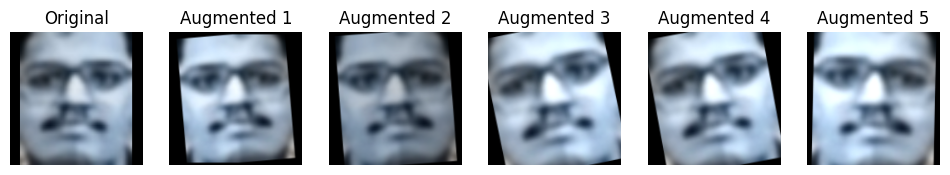

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


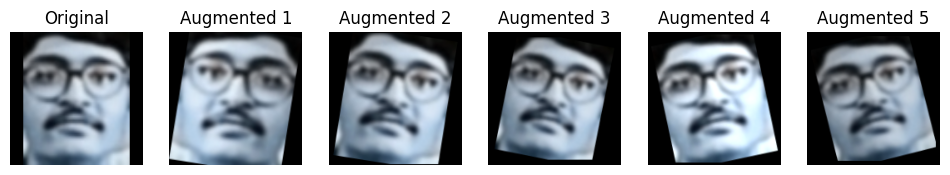

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


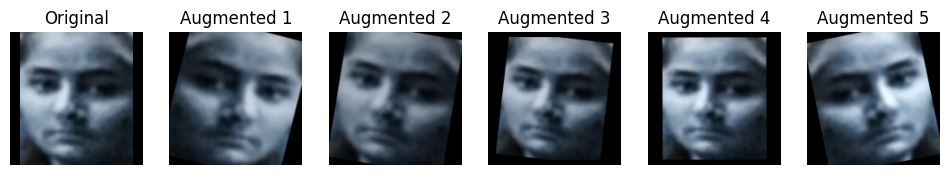

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


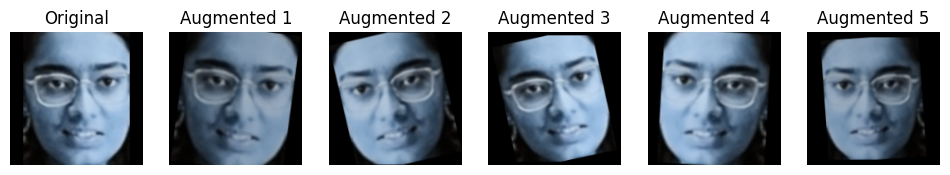

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


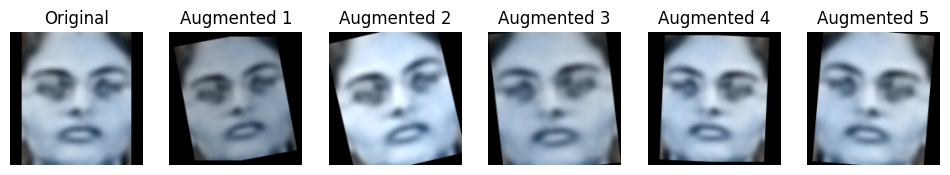

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


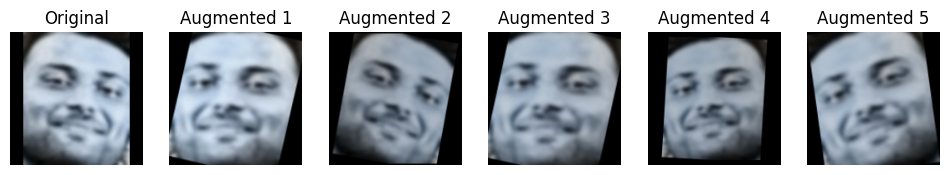

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


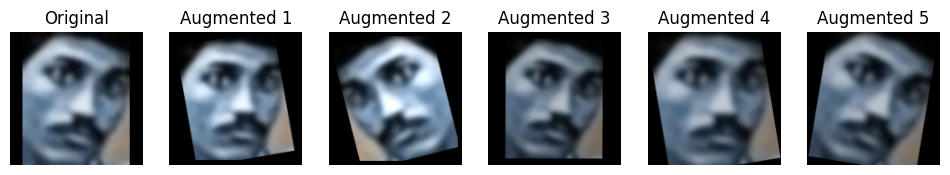

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


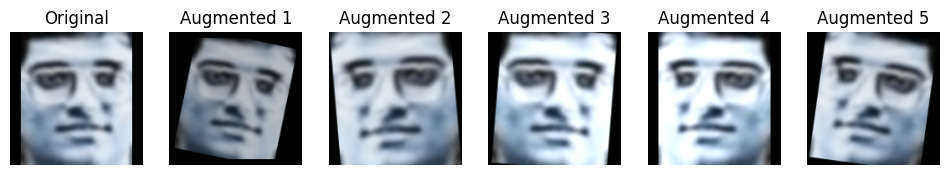

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


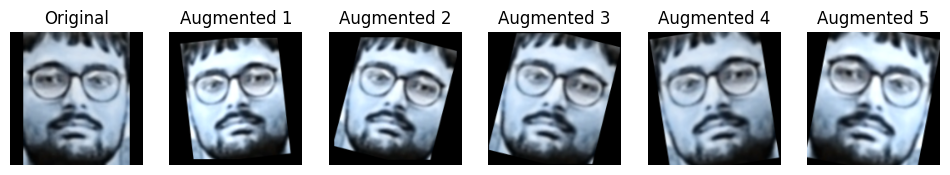

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


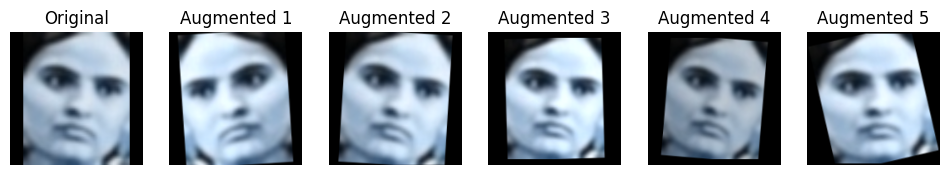

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


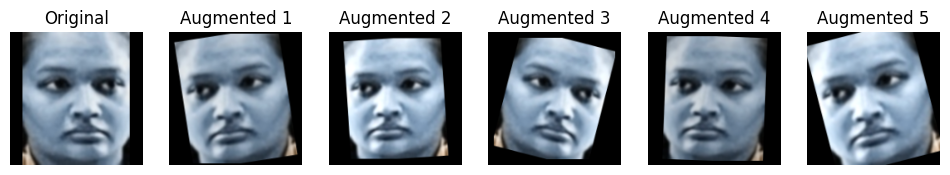

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


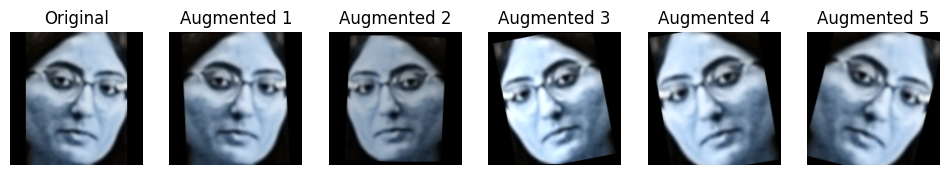

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


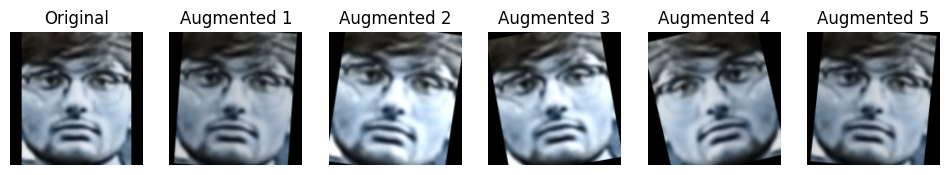

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


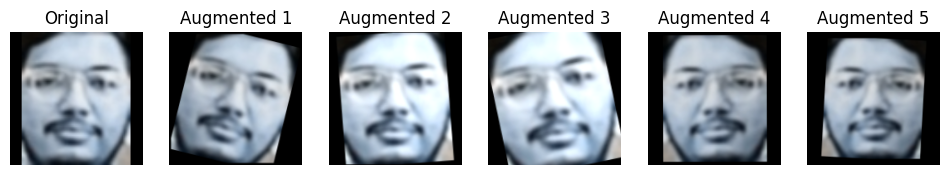

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


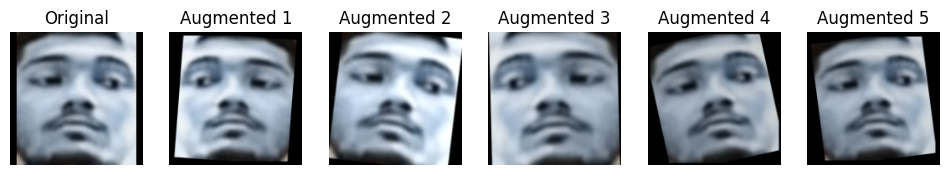

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


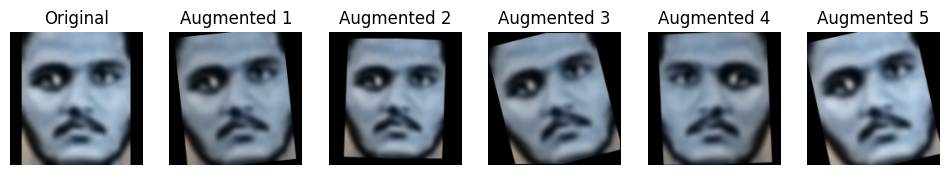

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


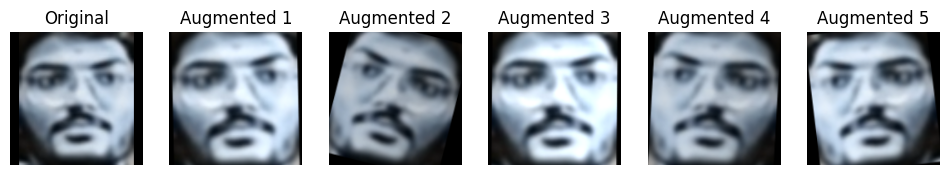

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


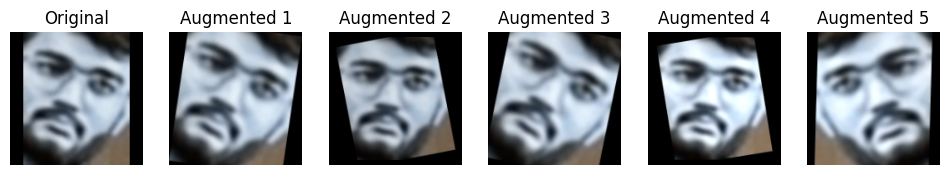

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


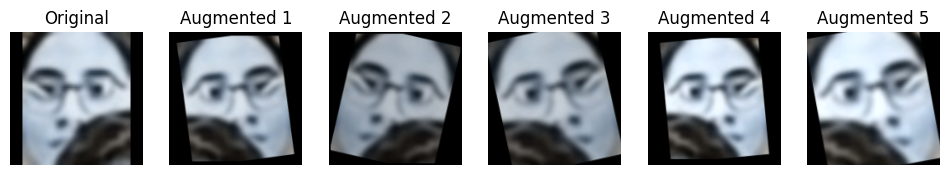

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


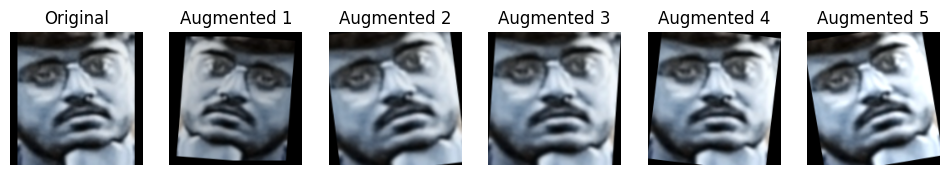

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


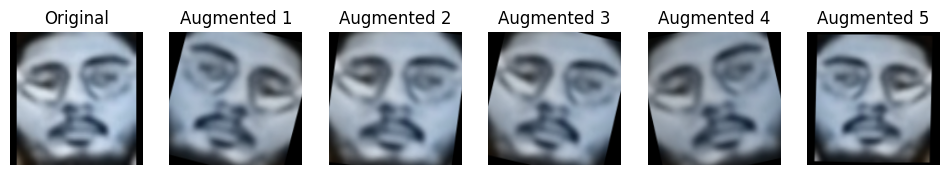

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


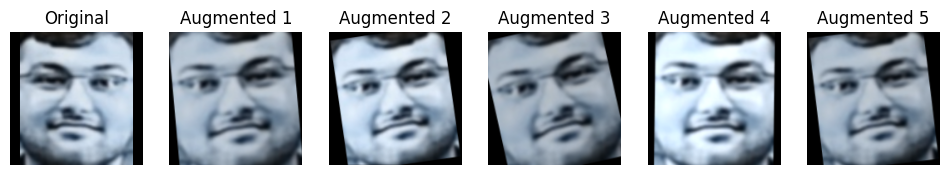

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


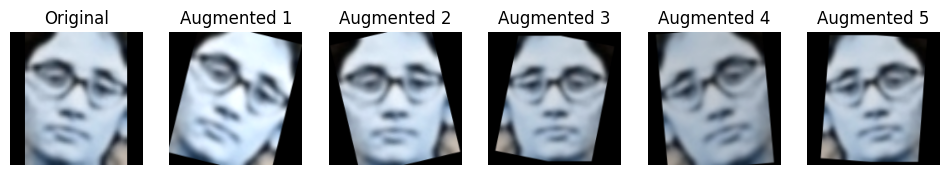

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Generated embeddings shape: (138, 512)
Number of labeled faces processed: 138


In [13]:
def main():
    dataset_path = "/kaggle/input/d/jetaniharshil/cvdldata/proper"
    
    embeddings, labels = generate_embeddings_with_augmentation(dataset_path)
    
    if len(embeddings) > 0:
        # Save embeddings and labels
        np.save('face_embeddings_with_aug.npy', embeddings)
        np.save('face_labels_with_aug.npy', labels)
        
        print(f"Generated embeddings shape: {embeddings.shape}")
        print(f"Number of labeled faces processed: {len(labels)}")
    else:
        print("No embeddings were generated. Please check the error messages above.")

if __name__ == "__main__":
    main()
